In [ ]:
pip install pymoo

In [2]:
import numpy as np
import scipy.optimize as opt
import time
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import deque
from scipy.optimize import differential_evolution
import tensorflow as tf
from tensorflow import keras
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
import pandas as pd
from pymoo.core.problem import Problem
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

Here is a dataset we collected from a Fashion and Beauty startup. The dataset is based on the supply chain of Makeup products. Below are all the features in the dataset:

https://www.kaggle.com/datasets/amirmotefaker/supply-chain-dataset



In [3]:
# Load Data
df = pd.read_csv("supply_chain_data.csv")
df.columns

Index(['Product type', 'SKU', 'Price', 'Availability',
       'Number of products sold', 'Revenue generated', 'Customer demographics',
       'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
       'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location',
       'Lead time', 'Production volumes', 'Manufacturing lead time',
       'Manufacturing costs', 'Inspection results', 'Defect rates',
       'Transportation modes', 'Routes', 'Costs'],
      dtype='object')

To address the inventory management problem (minimizing costs while maintaining a required service level), we need to focus on the relevant columns and formulate the problem accordingly.

Relevant Columns for Inventory Management
From the list of columns, the following are most relevant for inventory management:

- SKU: Stock Keeping Unit (unique identifier for each product).
- Stock levels: Current inventory levels for each SKU.
- Lead times: Time taken for replenishment (from order placement to receipt).
- Order quantities: Quantities ordered for each SKU.
- Price: Unit price of each SKU.
- Number of products sold: Demand for each SKU.
- Shipping costs: Transportation costs associated with replenishment.
- Manufacturing costs: Production costs (if applicable).
- Defect rates: Percentage of defective items (affects usable inventory).

## Inventory Management Problem Formulation

The goal is to minimize total inventory costs while maintaining a required service level. The total inventory cost includes:

- Holding Costs: Cost of storing inventory.
- Ordering Costs: Cost of placing orders.
- Shortage Costs: Cost of stockouts (lost sales or backorders).

## Objective Function
- Minimize: Total Cost= Holding Cost + Ordering Cost +
Shortage Cost
- Total Cost=Holding Cost+Ordering Cost+Shortage Cost

## Constraints
- Service Level Constraint: Ensure the probability of stockout does not exceed a specified threshold.
- Inventory Balance: Ensure inventory levels are non-negative and satisfy demand.

## Inventory Cost Function:

HEre the inventory_cost_function calculates the total inventory cost based on:

- Holding costs: Cost of storing inventory.

- Shortage costs: Cost of stockouts.

- Ordering costs: Fixed cost per order.

- Service level penalty: Penalty for not meeting the target service level (95%).

The function adjusts for defect rates and computes the total cost, which is minimized by the optimization algorithm.

In [4]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [5]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "mutation_strategies": ['best1bin', 'rand1bin', 'rand2bin', 'currenttobest1bin', 'best1exp', 'rand1exp'],
    "crossover_strategies": ['bin', 'exp'],
    "cma_step_size": 0.3,
    "egt_max_size": 50,
    "dqn_learning_rate": 0.001,
    "max_generations": 100,
    "num_runs": 10,
    "batch_size": 32}

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |             f
     3 |      300 |      1 |  2.210920E+05 |         ideal
     4 |      400 |      1 |  2.390023E+04 |         ideal
     5 |      500 |      1 |  4.892094E+04 |         ideal
     6 |      600 |      1 |  1.356302E+05 |         ideal
     7 |      700 |      2 |  2.1048030975 |         ideal
     8 |      800 |      3 |  1.9945399980 |         ideal
     9 |      900 |      2 |  1.034429E+01 |         ideal
    10 |     1000 |      1 |  1.880095E+04 |         ideal
    11 |     1100 |      3 |  1.0352655162 |         ideal
    12 |     1200 |      2 |  1.9758397255 |         ideal
    13 |     1300 |      2 |  1.7289487412 |         ideal
    14 |     1400 |      1 |  6.475320E+04 |         ideal
    15 |     1500 |      3 |  0.3351009659 |         ideal
    16 |     1600 |      5 |  0.7658698773 |         ide

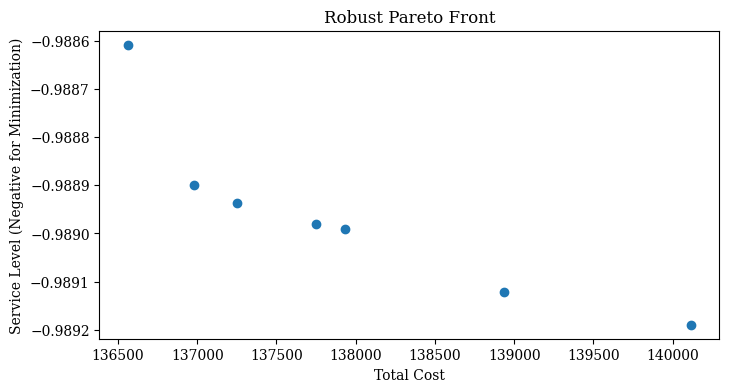

Robustness Metrics for Selected Solution: {'expected_cost': 136560.8679632385, 'worst_case_cost': 186601.99019780816, 'expected_service_level': 0.9886076591427924, 'worst_case_service_level': 0.9659640373635575}


In [6]:
df = df[['SKU', 'Stock levels', 'Lead times', 'Order quantities',
         'Number of products sold', 'Price', 'Shipping costs', 'Defect rates']]

# Constants
holding_cost_rate = 0.1  # 10% of unit price as holding cost
ordering_cost = 50  # Fixed cost per order
shortage_cost = 2 * df['Price'].values  # Shortage cost is twice the unit price
service_level_target = 0.95  # 95% SLA
demand = df['Number of products sold'].values
lead_time = df['Lead times'].values
defect_rate = df['Defect rates'].values / 100

scenarios = [
    demand * 0.8,  # Low demand scenario
    demand,        # Base demand scenario
    demand * 1.2   # High demand scenario
]

# Inventory Cost Function
def total_cost(x, demand_scenario):
    """Calculate total inventory cost for a given demand scenario."""
    order_quantities = x
    usable_quantities = order_quantities * (1 - defect_rate)
    inventory_level = df['Stock levels'].values + usable_quantities - demand_scenario
    holding_cost_total = np.sum(holding_cost_rate * df['Price'].values * np.maximum(inventory_level, 0), axis=1)
    shortage_cost_total = np.sum(shortage_cost * np.maximum(-inventory_level, 0), axis=1)
    ordering_cost_total = np.sum(ordering_cost * (order_quantities > 0), axis=1)
    service_level = 1 - (np.sum(np.maximum(-inventory_level, 0), axis=1) / np.sum(demand_scenario))
    service_level_penalty = 1e6 * np.maximum(0, service_level_target - service_level)
    return holding_cost_total + shortage_cost_total + ordering_cost_total + service_level_penalty

def service_level(x, demand_scenario):
    """Calculate service level for a given demand scenario."""
    order_quantities = x
    usable_quantities = order_quantities * (1 - defect_rate)
    inventory_level = df['Stock levels'].values + usable_quantities - demand_scenario
    return 1 - (np.sum(np.maximum(-inventory_level, 0), axis=1) / np.sum(demand_scenario))

# Multiobjective Problem
class InventoryProblem(Problem):
    def __init__(self, scenarios):
        self.scenarios = scenarios
        n_var = len(df)
        super().__init__(
            n_var=n_var,
            n_obj=2,
            n_constr=0,
            xl=np.zeros(n_var),
            xu=np.ones(n_var) * 1000  # Upper bounds (order quantities <= 1000)
        )

    def _evaluate(self, x, out, *args, **kwargs):
        """Evaluate the objectives for a population of solutions."""
        costs = []
        service_levels = []
        for scenario in self.scenarios:
            cost = total_cost(x, scenario)
            sl = service_level(x, scenario)
            costs.append(cost)
            service_levels.append(sl)
        # mean across scenarios for each solution
        mean_costs = np.mean(costs, axis=0)
        mean_service_levels = np.mean(service_levels, axis=0)
        out["F"] = np.column_stack([mean_costs, -mean_service_levels])  # Minimize cost, maximize service level

    def evaluate_robustness(self, x):
        """Calculate robustness metrics for a given solution."""
        x = np.atleast_2d(x)
        costs = []
        service_levels = []
        for scenario in self.scenarios:
            cost = total_cost(x, scenario)
            sl = service_level(x, scenario)
            costs.append(cost)
            service_levels.append(sl)

        costs = np.array(costs).flatten()
        service_levels = np.array(service_levels).flatten()
        return {
            "expected_cost": np.mean(costs),
            "worst_case_cost": np.max(costs),
            "expected_service_level": np.mean(service_levels),
            "worst_case_service_level": np.min(service_levels)}

problem = InventoryProblem(scenarios)

# Multiobjective Optimization (NSGA-II)
algorithm = NSGA2(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=True)

# Extract results
pareto_front = res.F
solutions = res.X

plt.figure(figsize=(8,4))
plt.scatter(pareto_front[:, 0], pareto_front[:, 1])
plt.xlabel("Total Cost")
plt.ylabel("Service Level (Negative for Minimization)")
plt.title("Robust Pareto Front")
plt.show()

# Evaluate robustness of a selected solution
selected_solution = solutions[0]
robustness_metrics = problem.evaluate_robustness(selected_solution)
print("Robustness Metrics for Selected Solution:", robustness_metrics)

In [7]:
def scalarized_objective(x):
    """Combine cost and service level into a single scalar value."""
    x = np.atleast_2d(x)
    costs = []
    service_levels = []
    for scenario in scenarios:
        cost = total_cost(x, scenario)
        sl = service_level(x, scenario)
        costs.append(cost)
        service_levels.append(sl)
    mean_cost = np.mean(costs)
    mean_service_level = np.mean(service_levels)

    weight_cost = 0.7
    weight_service_level = 0.3
    return weight_cost * mean_cost - weight_service_level * mean_service_level


class EGTMemory:
    def __init__(self, max_size=50):
        self.solutions = []
        self.fitness = []
        self.max_size = max_size

    def add_solution(self, solution, fitness):
        if len(self.solutions) < self.max_size:
            self.solutions.append(solution)
            self.fitness.append(fitness)
        else:
            worst_idx = np.argmax(self.fitness)
            if fitness < self.fitness[worst_idx]:
                self.solutions[worst_idx] = solution
                self.fitness[worst_idx] = fitness

    def extract_patterns(self):
        return np.mean(self.solutions, axis=0) if self.solutions else None

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def select_action(self, state):
        state = np.array(state).reshape(1, -1)
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states = np.array([x[0] for x in batch])
        actions = np.array([x[1] for x in batch])
        rewards = np.array([x[2] for x in batch])
        next_states = np.array([x[3] for x in batch])

        targets = rewards + self.gamma * np.max(self.model.predict(next_states, verbose=0), axis=1)
        target_f = self.model.predict(states, verbose=0)
        target_f[np.arange(batch_size), actions] = targets

        self.model.fit(states, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class AdaptiveEA:
    def __init__(self, objective_function, bounds, generations=50, num_runs=10):
        self.bounds = bounds
        self.objective_function = objective_function
        self.generations = generations
        self.num_runs = num_runs
        self.agent = DQNAgent(state_size=1, action_size=len(CONFIG["mutation_strategies"]))
        self.egt_memory = EGTMemory()

    def evolve(self):
        all_runs_fitness_history = []
        best_solution, best_fitness = None, float('inf')

        for run in range(self.num_runs):
            print(f"Run {run + 1}/{self.num_runs}")
            solution, fitness, fitness_history = self._evolve_single_run()
            all_runs_fitness_history.append(fitness_history)

            if fitness < best_fitness:
                best_solution, best_fitness = solution, fitness

        return best_solution, best_fitness, np.mean(all_runs_fitness_history), np.max(all_runs_fitness_history), np.std(all_runs_fitness_history), all_runs_fitness_history

    def _evolve_single_run(self):
        best_solution, best_fitness = None, float('inf')
        fitness_history = []
        strategies = CONFIG["mutation_strategies"]

        F_values = np.random.uniform(0.4, 0.9, size=len(strategies))
        CR_values = np.random.uniform(0.1, 0.9, size=len(strategies))
        stagnation_counter = 0

        for generation in range(self.generations):
            strategy_idx = self.agent.select_action([generation])
            mutation_strategy = strategies[strategy_idx]

            F = F_values[strategy_idx] + np.random.normal(0, 0.1)
            CR = CR_values[strategy_idx] + np.random.normal(0, 0.1)
            F, CR = np.clip(F, 0.1, 1.0), np.clip(CR, 0.1, 1.0)

            result = differential_evolution(
                self.objective_function,
                bounds=self.bounds,
                strategy=mutation_strategy,
                recombination=CR,
                popsize=20,
                tol=0.01,
                mutation=F,
                maxiter=1,
                disp=False,
                updating='deferred')

            if result.fun < best_fitness:
                best_fitness = result.fun
                best_solution = result.x
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if stagnation_counter >= 10:
                F_values = np.clip(F_values + np.random.normal(0, 0.05), 0.1, 1.0)
                stagnation_counter = 0

            self.egt_memory.add_solution(result.x, result.fun)
            fitness_history.append(result.fun)

            if np.random.rand() < 0.1:
                F_values[strategy_idx] = np.clip(F_values[strategy_idx] + np.random.normal(0, 0.02), 0.1, 1.0)
                CR_values[strategy_idx] = np.clip(CR_values[strategy_idx] + np.random.normal(0, 0.02), 0.1, 1.0)

            if generation % 10 == 0:
                pattern = self.egt_memory.extract_patterns()
                if pattern is not None:
                    result.x = pattern

            reward = -result.fun
            next_state = [generation + 1]
            self.agent.memory.append(([generation], strategy_idx, reward, next_state))
            self.agent.train()

        return best_solution, best_fitness, fitness_history

problem = InventoryProblem(scenarios)

adaptive_ea = AdaptiveEA(scalarized_objective, bounds=[(0, 1000)] * len(df), generations=50, num_runs=10)
best_solution, best_fitness, _, _, _, _ = adaptive_ea.evolve()

robustness_metrics = problem.evaluate_robustness(best_solution)
print("Robustness Metrics for Selected Solution (Hybrid Algorithm):", robustness_metrics)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Robustness Metrics for Selected Solution (Hybrid Algorithm): {'expected_cost': 104312.20413807104, 'worst_case_cost': 148185.97223247783, 'expected_service_level': 0.9893549429134554, 'worst_case_service_level': 0.9681612764895078}
